## cs8321 Lab 3 - CNN Visualization


#### Chip Henderson - 48996654

### Model Selection

I'm going to be using VGG-19 for this lab. There are a few reasons for selecting this model. 
 -  The architecture is fairly straightforward, so I won't have to worry about tracing my inputs through convoluted paths
 -  It is one of the models hosted in OpenAI's Microscope in case I want to compare what I'm seeing to what I should be
 -  The architecture is such that if I don't like the layer I'm working in it is easy to move to another

Let's pull in VGG-19 and try to classify some images. I don't have any image datasets locally to I need some representative samples to run through the model. It helps to understand what VGG was trained on in order to do this.

VGG-19 was trained on imagenet-1k, also known as ILSVRC 2012. This dataset contains images of varying class and is frequently used to pretrain deep learning models for computer vision. Here are some of the specifications:

 -  One thousand classes in total
 -  A datasplit of 1,281,167 training images, 50,000 validation images, and 100,000 test images was used
 -  The images in the dataset are classified using the WordNet hierarchy
 -  Each meaningful concept in WordNet, possibly described by multiple words or word phrases, is called a “synonym set” or “synset”. ImageNet aims to provide on average 1000 images to illustrate each synset.
 -  The images of each concept are quality-controlled and human-annotated.
 -  VGG19 is another good option for this lab. However, I'm being cognizant of my platform constraints and going with focusing on minimum viable models from a memory footprint perspective.

Source: https://paperswithcode.com/dataset/imagenet-1k-1#:~:text=The%20ImageNet1K%20dataset%2C%20also%20known,It%20spans%201000%20object%20classes.

In [90]:
# Source: https://keras.io/api/applications/
# Import the model, weights, and set up for classifiying test images

import keras
from keras.applications.vgg19 import VGG19
import numpy as np

model = VGG19(weights='imagenet', include_top=True)

model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

With the model imported, we'll pull a couple imageNet images to test performance. VGG needs an input image size of 224x224, so I'll be resizing to ensure the samples meet this requirement. I didn't want to download a full imagenet dataset, so I found a source providing one image from each of the 1,000 classes, and took 10 random samples from that.

Image Source: https://github.com/EliSchwartz/imagenet-sample-images/blob/master/README.md

In [91]:
# Source: Modified from https://keras.io/api/applications/
# and ChatGPT

import os
from tensorflow.keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions

# These function were provided by ChatGPT and verified against
# The Keras applications API https://keras.io/api/applications/
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array


def predict_image_class(img_path):
    img = preprocess_image(img_path)
    preds = model.predict(img)
    # Decode predictions, give the top 3
    decoded_preds = decode_predictions(preds, top=3)[0]
    return decoded_preds

images_dir = '../Data_Sources/imageNet_samples/'

# Get list of image filenames in the directory
image_files = os.listdir(images_dir)

# Iterate over each image and make predictions
for image_file in image_files:
    # print(image_file)
    img_path = os.path.join(images_dir, image_file)
    predictions = predict_image_class(img_path)
    print("Predictions for", image_file)
    for prediction in predictions:
        print(prediction)
    print('\n')

1/1 [==============================] - 1s 813ms/step
Predictions for n01440764_tench.JPEG
('n01440764', 'tench', 0.9938253)
('n13054560', 'bolete', 0.002359529)
('n01443537', 'goldfish', 0.0019312225)


1/1 [==============================] - 0s 207ms/step
Predictions for n01498041_stingray.JPEG
('n01496331', 'electric_ray', 0.92767084)
('n01498041', 'stingray', 0.0700595)
('n01910747', 'jellyfish', 0.0008553813)


1/1 [==============================] - 0s 189ms/step
Predictions for n01632458_spotted_salamander.JPEG
('n01632458', 'spotted_salamander', 0.96707857)
('n01630670', 'common_newt', 0.025336092)
('n01629819', 'European_fire_salamander', 0.0068619507)


1/1 [==============================] - 0s 208ms/step
Predictions for n01829413_hornbill.JPEG
('n01829413', 'hornbill', 0.9960253)
('n01616318', 'vulture', 0.0032243056)
('n01843383', 'toucan', 0.000642817)


1/1 [==============================] - 0s 195ms/step
Predictions for n02130308_cheetah.JPEG
('n02130308', 'cheetah', 0.7104

The outputs here align with expectation. VGG-19 could be forgiven for guesing the stingray is an electric ray. Pretty good overall.

### Multi-channel filter Selection

In order to select a particular filter I'll first zero in on which layer to use. I'm going to pull a reference image for the purposes of visulizing the activations.

(1, 224, 224, 3)


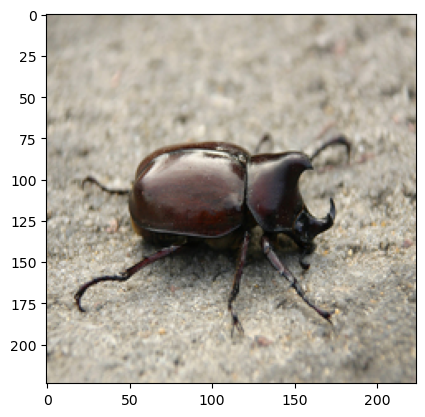

In [92]:
"""
Source: Modified from in class notebook 04 LectureVisualizingConvenets
Modified to work with VGG for image size, removed requests interface
since my images are local
"""

img_url = '../Data_Sources/imageNet_samples/n02174001_rhinoceros_beetle.JPEG'

# We preprocess the image into a 4D tensor
# from keras.preprocessing import image
import numpy as np
# import requests
# from io import BytesIO
from PIL import Image

def load_image_as_array(url, size=(224, 224)): # VGG requires 224x224 img size
    img = image.load_img(img_url) # open
    img = img.resize(size) # resize with PIL
    return np.array(img).astype(float) # return as numpy float array

def prepare_image_for_display(img, norm_type='max'):
    if norm_type == 'max':
        # min/max scaling, best for regular images
        new_img = (img - img.min()) / (img.max()-img.min())
    else:
        # std scaling, best when we are unsure about large outliers
        new_img = ((img - img.mean()) / (img.std() +1e-3))*0.15 + 0.5
        
    new_img *= 255
    new_img = np.clip(new_img, 0, 255)
    
    if len(new_img.shape)>3:
        new_img = np.squeeze(new_img)
        
    return new_img.astype('uint8')
    

img_tensor = load_image_as_array(img_url)
img_tensor = np.expand_dims(img_tensor, axis=0)
# Remember that the model was trained on inputs
# that were preprocessed in the following way:
img_tensor /= 255.

# Its shape is (1, 224, 224, 3)
print(img_tensor.shape)

import matplotlib.pyplot as plt

plt.imshow(prepare_image_for_display(img_tensor))
plt.show()

Now I'd like to get an idea of the shape of each activation's shape.

In [93]:
"""
Source: Modified from CS8321 class notebook 04 LectureVisualizingConvnets
I used ChatGPT to modify the activation model code to work with VGG19 
"""
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model

# Define the model to extract intermediate layer activations
# I've modified with layer_names instead of layer_outputs to work with the VGG19 model
layer_names = [layer.name for layer in model.layers[1:22]] 

activation_model = Model( # modified with ChatGPT code for outputs
    inputs=model.input, 
    outputs=[model.get_layer(layer_name).output for layer_name in layer_names]
)

# Get activations
activations = activation_model.predict(img_tensor)

# Print shapes of activations
for activation, layer in zip(activations,layer_names):
    print(activation.shape, layer)

1/1 [==============================] - 1s 546ms/step
(1, 224, 224, 64) block1_conv1
(1, 224, 224, 64) block1_conv2
(1, 112, 112, 64) block1_pool
(1, 112, 112, 128) block2_conv1
(1, 112, 112, 128) block2_conv2
(1, 56, 56, 128) block2_pool
(1, 56, 56, 256) block3_conv1
(1, 56, 56, 256) block3_conv2
(1, 56, 56, 256) block3_conv3
(1, 56, 56, 256) block3_conv4
(1, 28, 28, 256) block3_pool
(1, 28, 28, 512) block4_conv1
(1, 28, 28, 512) block4_conv2
(1, 28, 28, 512) block4_conv3
(1, 28, 28, 512) block4_conv4
(1, 14, 14, 512) block4_pool
(1, 14, 14, 512) block5_conv1
(1, 14, 14, 512) block5_conv2
(1, 14, 14, 512) block5_conv3
(1, 14, 14, 512) block5_conv4
(1, 7, 7, 512) block5_pool


[4 Points] Select a multi-channel filter (i.e., a feature) in a layer in which to analyze as part of a circuit. This should be a multi-channel filter in a "mid-level" portion of the network (that is, there are convolutional layers before and after this chosen layer). You might find using OpenAI microscope a helpful tool for selecting a filter to analyze without writing too much code: https://microscope.openai.com/models/Links to an external site. Using image gradient techniques, find an input image that maximally excites this chosen multi-channel filter. General techniques are available from class: https://github.com/8000net/LectureNotesMaster/blob/master/04%20LectureVisualizingConvnets.ipynbLinks to an external site. Also send images of varying class (i.e., from ImageNet) through the network and track which classes of images most excite your chosen filter. Give a hypothesis for what this multi-channel filter might be extracting. That is, what do you think its function is in the network? Give reasoning for your hypothesis. If using code from another source or a LLM, you should heavily document the code so that I can grade your understanding of the code used.

My analysis layer will be VGG19 block5_conv1. The choice if this layer is arbitrary, and based on suggestion from lecture. First, I'll pull all the activations from this layer. I can tell from above that block5_conv1 has 512 activations, and is therefore the result of 512 filters being applied to the previous layer's activations. The shape of those filters that were applied is 3x3x512, as the block4_pool layer also had 512 activations.

C:\Users\Chip\AppData\Local\Temp\ipykernel_15576\519166245.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(16, 32, filter + 1)


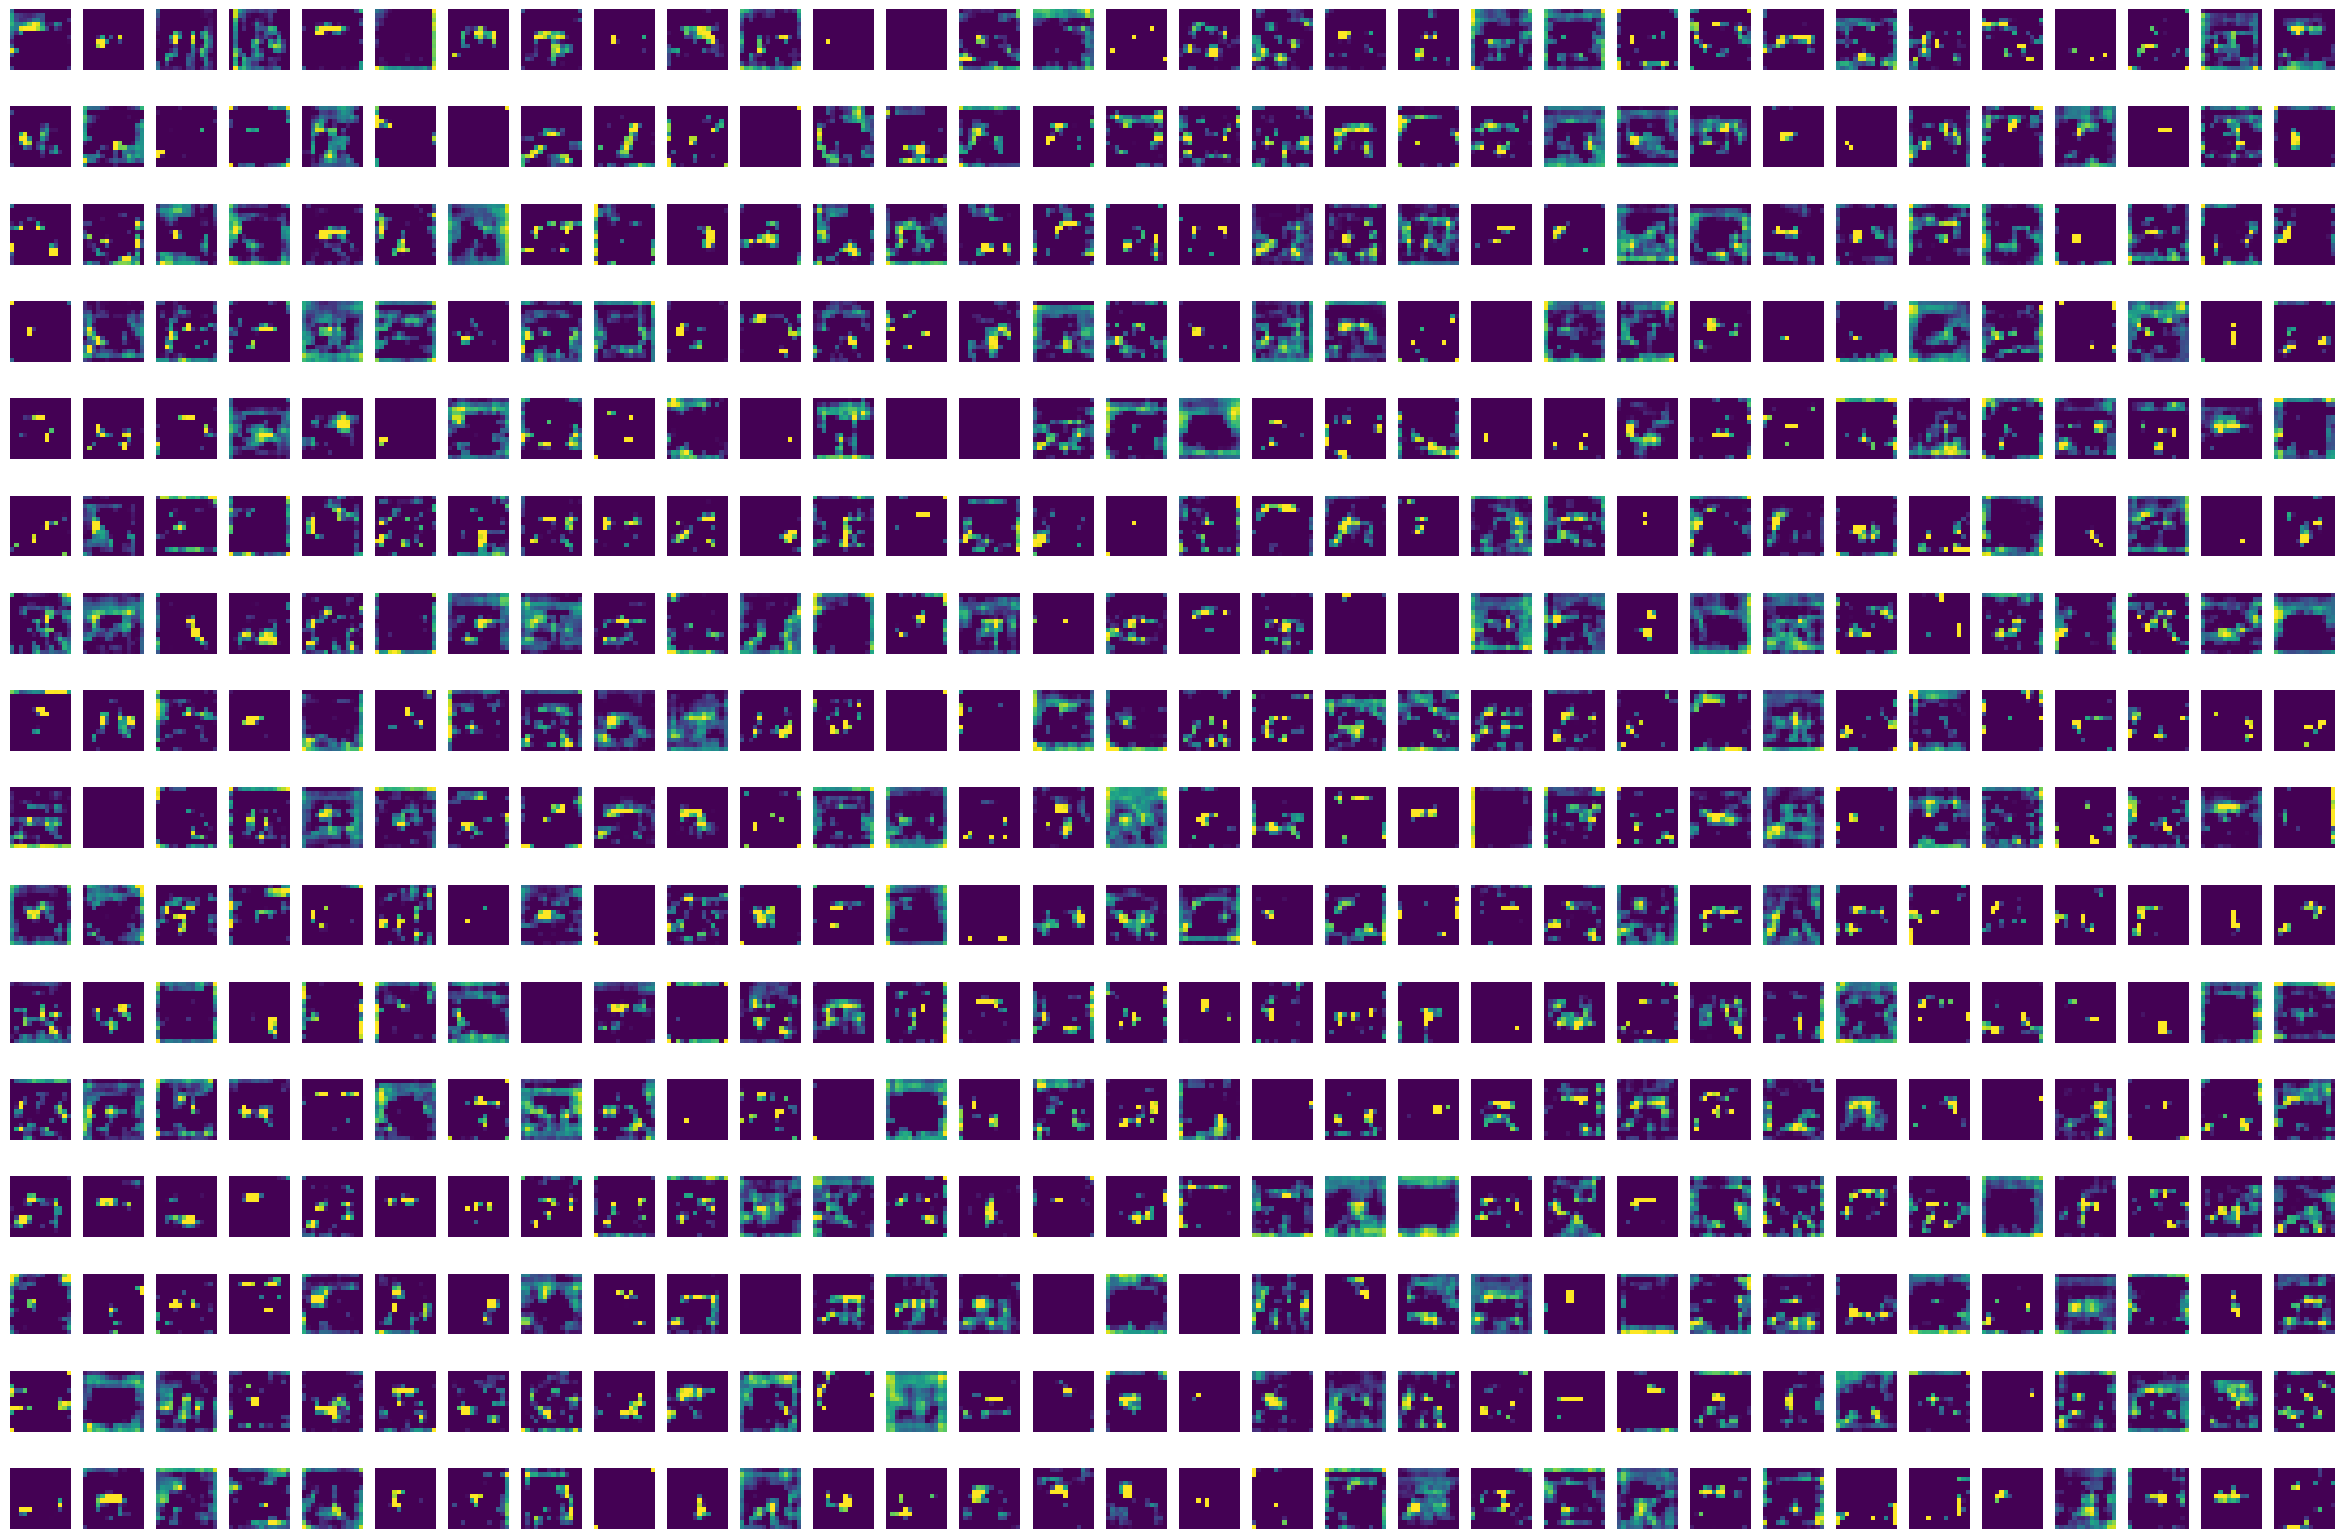

In [94]:
import matplotlib.pyplot as plt
from skimage.transform import resize

plt.subplots(figsize=(30,20))

for filter in range(512):
    ax = plt.subplot(16, 32, filter + 1) 
    channel = block5_conv1_activation[0, :, :, filter]
    # scaled_channel = resize(channel, (channel.shape[0] // 2, channel.shape[1] // 2))
    plt.grid(False)
    plt.imshow(
        prepare_image_for_display(channel, norm_type='std'),
        # aspect='auto',
    )
    ax.axis('off')
    
    
plt.show()

From a visual analysis, I'm looking for an activation that was fairly responsive to the input, essentially one with lighter colors that are focused on the subject of the image. I could chose any that have lighter colors, but they might be picking up on things that are harder to differentiate.

In [95]:
model.layers[15].filters # debug

512

I'll run my selection of images through this filter to see what kinds of images excite it.

block5_conv1 Filter 279


C:\Users\Chip\AppData\Local\Temp\ipykernel_15576\2497008185.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,2,1)


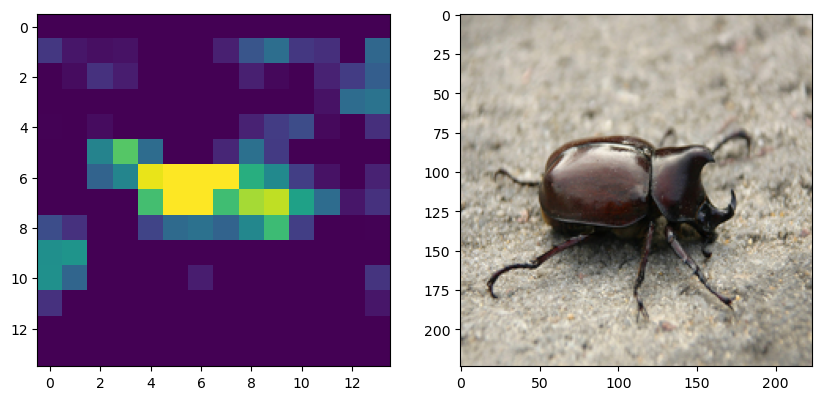

In [112]:
idx_filter = 279
# Block 5 conv1 is the 17th layer of those I've selected
block5_conv1_activation = activations[16] # get activation from list
print(layer_names[16], "Filter", idx_filter)

one_channel = block5_conv1_activation[0, :, :, idx_filter] # get single activation channel
plt.subplots(figsize=(10,20))
ax = plt.subplot(1,2,1) 

plt.imshow(prepare_image_for_display(one_channel,
                                     norm_type = 'std'))
ax = plt.subplot(1,2,2) 
plt.imshow(prepare_image_for_display(img_tensor))


plt.show()

In [109]:
# print(image_files) # debug

Based on visually comparing my image to this activation my hypothesis that this activation is focused on edge detection and reflectivity, or how shiny an object might be. There may also be an element of curvature detection.

To prove my hypothesis, I'll seek to find images that maximally excites this activation.

[4 Points] Analyze each channel of the multi-channel filter to better understand how this might form a circuit (i.e., the weights of the filter). That is, visualize the convolutional filter (one channel at a time) between the input activations and the current activation to understand which inputs make up a circuit. You should avoid filter channels that are mostly "zero" coefficients. These are not influential for the circuit. One method of doing this is given below: Extract the filter coefficients for each input activation to that multi-channel filter. Note: If the multi-channel filter is 5x5 with an input channel size of 64, then this extraction will result in 64 different single channel filters, each of size 5x5. Keep the top ten sets of inputs with the "strongest" weights. For now, you can use the L2 norm of each input filter as a measure of strength. Visualize these top ten filters. For these ten strongest input filters, categorize each as "mostly inhibitory" or "mostly excitatory." That is, does each filter consist of mostly negative or mostly positive coefficients?